In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM,Bidirectional, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE=20000
EMBEDDING_DIM=100
EPOCHS=10
BATCH_SIZE=512

In [3]:
print("[] Info: Loading Word2Vecs ... ")
word2vec = {}

glove_file = open('glove6d/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    word2vec[word] = vector_dimensions
glove_file.close()

[] Info: Loading Word2Vecs ... 


In [4]:
train = pd.read_csv('toxic_data/train.csv')
sentences = train['comment_text'].fillna('DUMMY_VALUE').values
possible_labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
target = train[possible_labels].values

In [5]:
print(f"Max length of Sequence is : {max(len(s) for s in sentences)}")
print(f"Min length of Sequence is : {min(len(s) for s in sentences)}")
s = sorted(len(s) for s in sentences)
print(f"Median length of Sequence is : {s[len(s) // 2]}")

Max length of Sequence is : 5000
Min length of Sequence is : 6
Median length of Sequence is : 205


In [6]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [7]:
word2idx = tokenizer.word_index
print(f"Length of Unique words are {len(word2idx)}")

Length of Unique words are 210337


In [8]:
data = pad_sequences(sequences,maxlen= MAX_SEQUENCE_LENGTH)
print(data.shape)

(159571, 100)


In [9]:
num_words = min(MAX_VOCAB_SIZE,len(word2idx)+1)

In [10]:
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, index in word2idx.items():
    if index < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [11]:
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights = [embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False)

In [12]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(15,return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
output = Dense(len(possible_labels),activation='sigmoid')(x)

model = Model(input_, output)
model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 30)           13920     
_________________________________________________________________
global_max_pooling1d (Global (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 186       
Total params: 2,014,106
Trainable params: 14,106
Non-trainable params: 2,000,000
_________________________________________________________________


In [13]:
r = model.fit(data, target, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 9s 19ms/step - loss: 0.1822 - accuracy: 0.5799 - val_loss: 0.0789 - val_accuracy: 0.9916
Epoch 2/10
250/250 [==============================] - 4s 15ms/step - loss: 0.0687 - accuracy: 0.9925 - val_loss: 0.0638 - val_accuracy: 0.9937
Epoch 3/10
250/250 [==============================] - 4s 15ms/step - loss: 0.0607 - accuracy: 0.9932 - val_loss: 0.0600 - val_accuracy: 0.9933
Epoch 4/10
250/250 [==============================] - 4s 15ms/step - loss: 0.0572 - accuracy: 0.9928 - val_loss: 0.0586 - val_accuracy: 0.9935
Epoch 5/10
250/250 [==============================] - 4s 15ms/step - loss: 0.0551 - accuracy: 0.9907 - val_loss: 0.0560 - val_accuracy: 0.9872
Epoch 6/10
250/250 [==============================] - 4s 15ms/step - loss: 0.0534 - accuracy: 0.9862 - val_loss: 0.0566 - val_accuracy: 0.9762
Epoch 7/10
250/250 [==============================] - 4s 15ms/step - loss: 0.0521 - accuracy: 0.9845 - val_loss: 0.0569 - val_accuracy: 0.9828

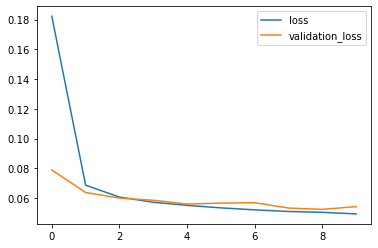

In [14]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.show()

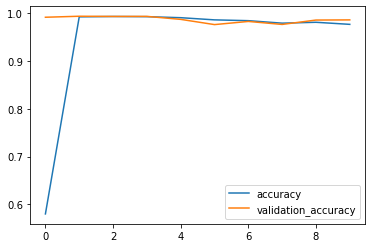

In [15]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'validation_accuracy')
plt.legend()
plt.show()

In [16]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(target[:,j], p[:,j])
    aucs.append(auc)

In [17]:
print(np.mean(aucs))

0.9774056227966295


In [18]:
print(aucs)

[0.9702591458726451, 0.9870490228030352, 0.9837993161998451, 0.964036153480608, 0.9788729116155859, 0.9804171868080578]
